Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_summary()`).”


Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_summary()`).”


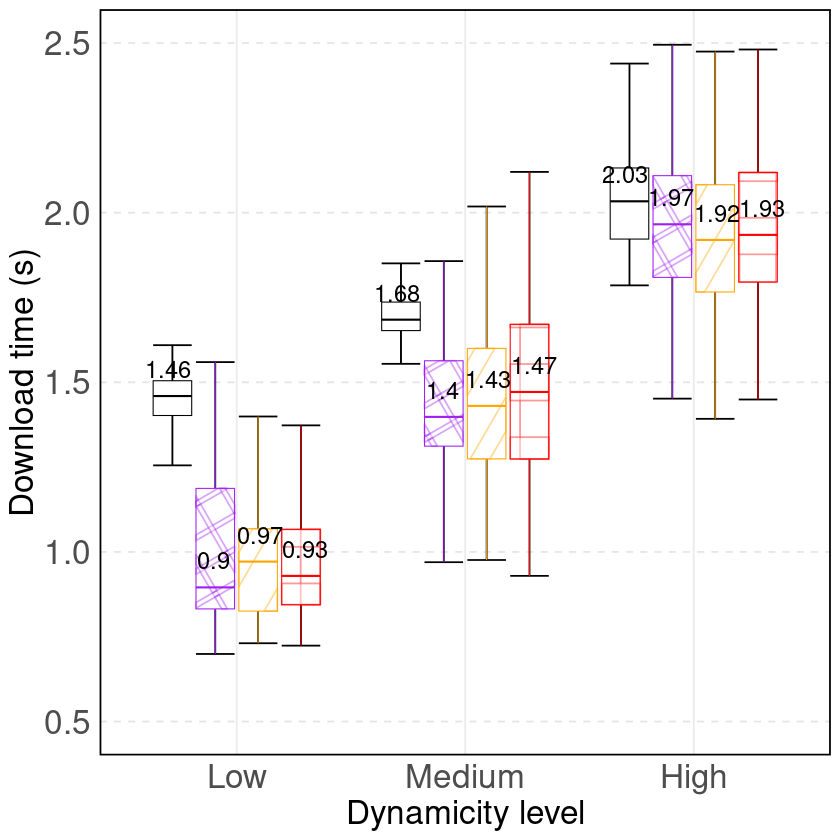

In [9]:
library(ggplot2)
library(dplyr)
library(readr)
library(ggpattern)

# Define variables
column_names <- c("Download Time")
schedules <- c("RR", "WRR", "SWRR", "NII")
bwd <- 0
owd <- 0
web <- "amazon.com"
brw <- "chrome"

# Define scenarios and labels
scenarios <- c(
  paste0(web, "-0-0-", bwd, "-", owd, "-0-0-LowLatency"),
  paste0(web, "-0-0-", bwd, "-", owd, "-8-1.5-LowLatency"),
  paste0(web, "-0-0-", bwd, "-", owd, "-16-3-LowLatency")
)
scenarios_label <- c("Low", "Medium", "High")

# Create an empty list to store all download times
all_download_times <- list()

# Read data from CSV files and store it in the list
for (sch in schedules) {
  for (scenario in scenarios) {
    file_path <- paste0("../output/",brw,"/none-1-", scenario, "-", sch, "-",brw,"-result.csv")
    
    data <- tryCatch(
      read_csv(file_path, col_names = column_names, show_col_types = FALSE),
      error = function(e) {
        message("Warning: File not found or could not be read: ", file_path)
        return(NULL) 
      }
    )
    
    if (!is.null(data)) {
      data <- data %>%
        mutate(
          `Download Time` = `Download Time`,
          Schedule = sch,
          FileSize = factor(scenario, levels = scenarios, labels = scenarios_label)
        )
      all_download_times[[length(all_download_times) + 1]] <- data
    }
  }
}

# Combine all data frames in the list into a single data frame
plot_data <- bind_rows(all_download_times)

# Map schedule to readable names
schedule_mapping <- c("RR" = "RR", "WRR" = "WRR", "SWRR" = "sWRR", "NII" = "dWRR")
plot_data$Schedule <- factor(plot_data$Schedule, levels = schedules, labels = schedule_mapping[schedules])

# Define colors and patterns directly as named vectors for factor levels
plot_colors <- c("RR" = "black", "WRR" = "purple", "sWRR" = "orange", "dWRR" = "red")
patterns <- c("Path1" = "crosshatch", "Path2" = "stripe", "RR" = "circle", 
              "WRR" = "weave", "sWRR" = "stripe", "dWRR" = "crosshatch")
# Create the boxplot with patterns and no background fill
ggplot(plot_data, aes(x = FileSize, y = `Download Time`, pattern = Schedule)) +
  stat_boxplot(geom = 'errorbar') +
  geom_boxplot_pattern(
    aes(
      pattern = Schedule, 
      pattern_angle = Schedule, 
      col = Schedule, 
      pattern_colour = Schedule, 
      pattern_spacing = Schedule, 
      pattern_density = Schedule
    ),
    pattern_fill = 'white',       # Background of pattern is white
    pattern_size = 0.5,
    pattern_alpha = 0.4,
    outlier.shape = NA,
    fill = 'white',               # Box background is white
    alpha = 1,
    lwd = 0.3
  ) +
  scale_pattern_manual(values = patterns) +
  scale_pattern_size_manual(values = 0.3) +
  scale_pattern_colour_manual(values = plot_colors) +  # Color of pattern lines
  scale_color_manual(values = plot_colors) +           # Color of box borders
  scale_y_continuous(limits = c(0.5, 2.5)) + # Set Y-axis limits
  labs(x = "Dynamicity level", y = "Download time (s)") +
  theme_minimal() +
  theme(
    text = element_text(size = 20),
    axis.text.x = element_text(size = 20),
    axis.text.y = element_text(size = 20),
    panel.grid.major.y = element_line(color = "gray90", linetype = "dashed"),
    panel.grid.minor = element_blank(),
    legend.position = "none",
    legend.title = element_blank(),
    panel.border = element_rect(color = "black", fill = NA, size = 1)
  ) +
  stat_summary(
    fun = median, 
    geom = "text", 
    aes(label = round(..y.., 2)), 
    vjust = -1, 
    position = position_dodge(width = 0.8),  # Dùng position_dodge để tách nhãn
    size = 5
  ) +
    guides(fill = guide_legend(nrow = 1), pattern = guide_legend(nrow = 1)) # Single line for legend

ggsave(file="downloadtime-static.pdf", device = cairo_pdf,  width = 6, height = 6, units = "in") #family="Times",
